## Things to keep in mind
* CAMB is only accurate at the 0.1% level (by default)
* Similarly, the numerical methods to obtain the position of the linear point have errors of the same order (kmin, kmax, smoothing kernel...)
* Therefore the results should only be trusted at that level.
* The ratio between linear point and r_drag should probably not be used. That's because it looks like a "conspiracy" of errors is happening where the line get's very wiggle. These wiggles are not random and are almost certainly coming from CAMB.
* That can be seen better when Plotting P(k, omch2) - P(k, omch2_fid) for varying omch2 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.pylab as pylab
import matplotlib as mpl
# functions to get LP from cosmology
import linear_point as lp
# doing cosmological calculations from parameters
import camb

%matplotlib inline

In [2]:
# for plots
sns.set_style("ticks",
             rc = {'axes.grid' : False,
                  'grid.linestyle' : 'dashed',
                  "xtick.direction": "in","ytick.direction": "in"})

sns.set_context('paper', font_scale=1.7)
pylab.rcParams['xtick.major.pad']='6'
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

sns.set_palette("Set1")

In [3]:
# creanting instance of CAMBparams object
pars = camb.CAMBparams()
# krange
kmin = 0.001
kmax = 10.

In [5]:
pars.set_accuracy(AccuracyBoost=1.5);

In [6]:
# fiducial TT,TE,EE + lowP
ombh2_fid=0.02225
omch2_fid=0.1198
theta_fid = 1.04077/100
h_fid = 0.6790
tau_fid = 0.079
ns_fid=0.9645
As_fid=2.207e-9
# sigmas
ombh2_sig = 0.00016
omch2_sig = 0.0015
ns_sig = 0.0049

In [7]:
def get_results(pars, z=0, ombh2 = ombh2_fid, omch2 = omch2_fid,
                h = h_fid, tau = tau_fid, As = As_fid, ns = ns_fid):
    pars.set_cosmology(ombh2=ombh2,
                       omch2 =omch2,
                       H0=100*h,
                       tau=tau)
    pars.InitPower.set_params(ns=ns,
                              As=As)
    pars.set_matter_power(
        redshifts=[z], kmax=kmax, nonlinear=False, k_per_logint=0)
    return camb.get_results(pars)

def get_lp(results, kmin=kmin, kmax=kmax):
    dip, peak = lp.lp_from_cosmo_mpc(results, kmin, kmax)
    return (dip+peak)/2

def get_rd(results):
    return results.get_derived_params()['rdrag']

def get_lp_rd_ratio(results):
    lp = get_lp(results)
    rd = get_rd(results)
    return lp/rd

In [8]:

# fiducial
results = get_results(pars)
lp_fid = get_lp(results)
rd_fid = get_rd(results)
print("lp_fid:{:.2f} , rd_fid:{:.2f}".format(lp_fid, rd_fid))

lp_fid:138.24 , rd_fid:147.28


In [9]:
# for parameter exploration
steps = 50
sigma_range = 10
# getting values
ombh2_vals = np.linspace(ombh2_fid - sigma_range*ombh2_sig,
                         ombh2_fid + sigma_range*ombh2_sig, steps)

omch2_vals = np.linspace(omch2_fid - sigma_range*omch2_sig,
                         omch2_fid + sigma_range*omch2_sig, steps)

ns_vals = np.linspace(ns_fid - sigma_range*ns_sig,
                         ns_fid + sigma_range*ns_sig, steps)

In [ ]:
# getting results
#ombh2
df_ombh2 = pd.DataFrame(columns=['ombh2','lp','rd'])

for i, ombh2 in enumerate(ombh2_vals):
    results = get_results(pars, ombh2 = ombh2)
    df_ombh2.loc[i] = [ombh2, get_lp(results), get_rd(results)]
    
print("Done with ombh2")
#ombh2
df_omch2 = pd.DataFrame(columns=['omch2','lp','rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    df_omch2.loc[i] = [omch2, get_lp(results), get_rd(results)]

print("Done with omch2")
#ombh2
df_ns = pd.DataFrame(columns=['ns','lp','rd'])

for i, ns in enumerate(ns_vals):
    results = get_results(pars, ns = ns)
    try:
        df_ns.loc[i] = [ns, get_lp(results), get_rd(results)]
    except:
        print("Broke when ns={}".format(ns))
        df_ns.loc[i] = np.nan
    
print("Done with ns")

## Plotting r/rfid

In [ ]:
dfs = [df_ombh2, df_omch2, df_ns]
# outlier and nan exclusion (the rootfinding is misfiring very rarely
# should look into that when there is time
z_threshold = 3 #how many sigmas to qualify as an outlier
for i, df in enumerate(dfs):
    z = np.abs(df - df.mean())/df.std() # get z for every entry
    print("Dropping") if (z > z_threshold).any().any() else print("Not Dropping")
    df = df.loc[~(z > z_threshold).any(axis=1)] #drops rows that have outliers
    df = df.dropna() #drop nans
    dfs[i] = df

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(14,4), sharey=True)
axes = [ax1, ax2, ax3]
factor = rd_fid/lp_fid
# ax1
for ax, df in zip(axes,dfs):
#     data = (factor*df.loc[:,'lp']/df.loc[:,'rd']).to_frame()
#     data.index = df.iloc[:,0]
#     data = data.rolling(3,win_type='gaussian', center=True).mean(std=2)
# #     data = data.rolling(3,win_type='gaussian', center=True).mean(std=2)
#     data = data.rolling(3, center=True).mean()
#     data = data.rolling(3, center=True).mean()
#     data.plot(ax=ax, legend=False)
    ax.plot(df.iloc[:,0], factor*df.loc[:,'lp']/df.loc[:,'rd'],'k')
    ax.set_xlabel(df.columns[0])

ax1.set_ylabel(r'normalized $r_{lp}/r_{d}$') # update label - normalized ratio now
#
plt.subplots_adjust(wspace=0.1)

# plt.savefig('./Figures/lp_rd/rlp_over_rdrag.pdf', dpi=200,
#            bbox_inches='tight')

plt.show()

##  plotting r/rfid - analysing errors

### From the analysis done below, it seems the bumps in omch2 are NOT due to:
* rdrag
* Gaussian kernel (which already introduces 1e-4 errors)
* Integration limits
* Rootfinding method
* Interpolation method
* Limits in k
* Sampling to find root-finding brackets
* Number of samples to interpolate

A lot of these things introduct O(1e-4) error, but they do so uniformly, not really explaining the bumps seen. Given that these errors are of the same order, I think smoothing out the bump is fine since we can't trust those decimal points anyway.

**Also important** is the fact that other parameters have the linear point vary over the same scale, but no bumps are seen. That suggests to me that the **problem is coming from CAMB**. More specifically, from how P(k) might be sensitive to omch2

In [7]:
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns.pkl')

In [8]:
dfs = [df_ombh2, df_omch2, df_ns]
# outlier and nan exclusion (the rootfinding is misfiring very rarely
# should look into that when there is time
z_threshold = 3 #how many sigmas to qualify as an outlier
for i, df in enumerate(dfs):
    z = np.abs(df - df.mean())/df.std() # get z for every entry
    print("Dropping") if (z > z_threshold).any().any() else print("Not Dropping")
    df = df.loc[~(z > z_threshold).any(axis=1)] #drops rows that have outliers
    df = df.dropna() #drop nans
    dfs[i] = df

Not Dropping
Dropping
Dropping


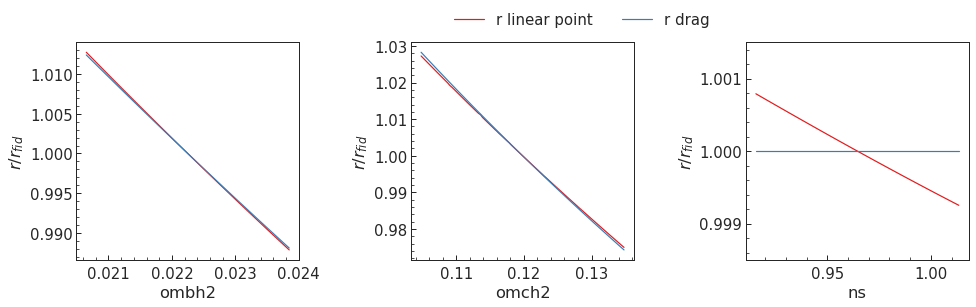

In [9]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,4), sharey=False)
axes = [ax1, ax2, ax3]

# plotting
for ax, df in zip(axes,dfs):
    ax.plot(df.iloc[:,0], df.loc[:,'lp']/lp_fid, label='r linear point')
    ax.plot(df.iloc[:,0], df.loc[:,'rd']/rd_fid, label='r drag')
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(r'$r/r_{fid}$')

# legend
ax1.legend(loc='best',ncol=2,frameon=False, bbox_to_anchor=(2.9, 1.2))

#
plt.subplots_adjust(wspace=0.5)

ax3.set_ylim(0.9985,1.0015)
ax3.set_yticks([0.999, 1.000, 1.001])


# plt.savefig('./Figures/lp_rd/r_over_r_fid_lp_and_rdrag.pdf', dpi=200,
#            bbox_inches='tight')
plt.show()

## plotting r_lp/r_drag

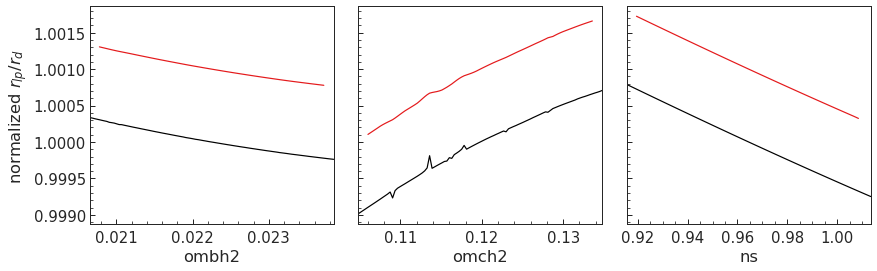

In [47]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(14,4), sharey=True)
axes = [ax1, ax2, ax3]
factor = rd_fid/lp_fid
# ax1
for ax, df in zip(axes,dfs):
    data = (factor*df.loc[:,'lp']/df.loc[:,'rd']).to_frame()+0.001
    data.index = df.iloc[:,0]
    data = data.rolling(5,win_type='gaussian', center=True).mean(std=3)
    data = data.rolling(5,win_type='gaussian', center=True).mean(std=3)
    data.plot(ax=ax, legend=False)
    ax.plot(df.iloc[:,0], factor*df.loc[:,'lp']/df.loc[:,'rd'],'k')
    ax.set_xlabel(df.columns[0])

ax1.set_ylabel(r'normalized $r_{lp}/r_{d}$') # update label - normalized ratio now
#
plt.subplots_adjust(wspace=0.1)

# plt.savefig('./Figures/lp_rd/rlp_over_rdrag.pdf', dpi=200,
#            bbox_inches='tight')

plt.show()

(0.9995, 1.0001)

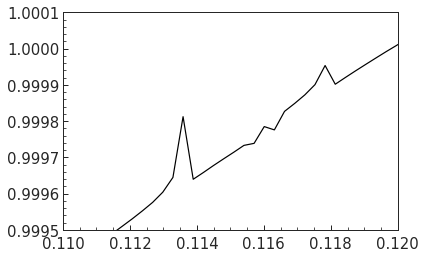

In [11]:
plt.plot(df_omch2.iloc[:,0], factor*df_omch2.loc[:,'lp']/df_omch2.loc[:,'rd'],'k')
plt.xlim(0.11,0.12)
plt.ylim(0.9995, 1.0001)

## Focus on the noisy region of omch2

In [16]:
from scipy import interpolate
from scipy.integrate import quad
from scipy.optimize import brentq, bisect
from scipy.interpolate import CubicSpline

In [17]:
def get_lp(xi_r, rmin=60., rmax=130., rsamples=10, root_dr=5.):
    """Given first derivative of matter correlation function, get position of
    dip and peak.
    - pars
    xi_r: function object, first derivative of xi(r)
    rmin, rmax: floats, range to which look for roots
    rsamples: int, derivative is sampled evenly in rsamples parts along specified range
    root_dr: float, interval around each root to do a finer search with brentq
    - returns
    dip, peak: float, position of dip and peak of correlation function"""
    # sample derivative in rsamples points and interpolate
    r_list = np.linspace(rmin, rmax, rsamples)
    xi_r_list = [xi_r(r) for r in r_list]
    xi_r_interp = CubicSpline(r_list, xi_r_list, extrapolate=False)
    # find roots of interpolated function
    roots = xi_r_interp.roots(extrapolate=False)
    # defined region to look for each root in derivative
    ra = (roots[0] - root_dr, roots[0] + root_dr)
    rb = (roots[1] - root_dr, roots[1] + root_dr)
    # find each root and return
#     dip = brentq(xi_r, *ra)
#     peak = brentq(xi_r, *rb)
    dip = bisect(xi_r, *ra)
    peak = bisect(xi_r, *rb)
    return dip, peak

In [18]:
def xi_r(r, pk, a=1., n=4):
    """First derivative of two point correlation function.
    - pars
    r: float, correlation scale in real space
    pk: interp function object, power spectrum as function of k, P(k),
    limits of integration are given by this object through the x attribute 
    a, n: parameters for filter exp(-(k/a)^n)
    - returns
    xi_r(r): float, value of first derivative of correlation func at r"""
    # sin and cos are omitted in the integrand because they're being weighted in quad
    def int_a(k): return k**2 * np.exp(-(k / a)**n) * \
        pk(k) / (2 * (np.pi**2) * r)

    def int_b(k): return -1 * k**2 * np.exp(-(k / a)**n) * \
        pk(k) / (2 * (np.pi**2) * k * r**2)
    # small shift on integration limitis to stay within
    # interpolation bounds
    xi_r_a = quad(int_a, pk.x[0]*(1+1e-8), pk.x[-1]*(1-1e-8), weight='cos', wvar=r)
    xi_r_b = quad(int_b, pk.x[0]*(1+1e-8), pk.x[-1]*(1-1e-8), weight='sin', wvar=r)
    return xi_r_a[0] + xi_r_b[0]

In [19]:
def get_pk_func(results, khmin, khmax, k_hunit=True):
    """Given cambs results object, calculate power spectrum as function of k.
    - pars
    results: camb's results object
    kmin, kmax: floats, limits in k space"""
    kh, z, [pk] = results.get_matter_power_spectrum(minkh=khmin,
                                                    maxkh=khmax,
                                                    npoints=1000)
    if k_hunit:
        return CubicSpline(kh, pk)
    else:
        h = results.hubble_parameter(0)/100
        return CubicSpline(kh*h, pk)

In [20]:
def lp_from_cosmo_mpc(results, khmin=0.001, khmax=10., a=1., n=4, rmin=115., rmax=160., rsamples=14, root_dr=5.):
    """Given cambs results object, calculate positions of dip and peak in Mpc.
    - pars
    results: camb's results object
    kmin, kmax: floats, limits in k space (should be consistent with limis in results)
    a, n: parameters for filter exp(-(k/a)^n)
    rmin, rmax, rsamples, root_dr: parameters for root finding of peak and dip in xi(r)
    - returns
    dip, peak: set, floats"""
    pk_func = get_pk_func(results, khmin, khmax, k_hunit=False)
    
    def dxi_dr(r): return xi_r(r, pk_func, a, n)
    lp = get_lp(dxi_dr, rmin, rmax, rsamples, root_dr)
    return lp

In [21]:
kmin = 1e-3
kmax = 10.

In [22]:
def get_lp_2(results, kmin=kmin, kmax=kmax):
    dip, peak = lp_from_cosmo_mpc(results, kmin, kmax,n=8)
    return (dip+peak)/2

In [23]:
get_lp_2(results)

138.24297115084156

In [37]:
camb.model.AccuracyParams()

class: <AccuracyParams>
 AccuracyBoost = 1.0
 lSampleBoost = 1.0
 lAccuracyBoost = 1.0
 AccuratePolarization = True
 AccurateBB = False
 AccurateReionization = True
 TimeStepBoost = 1.0
 BackgroundTimeStepBoost = 1.0
 IntTolBoost = 1.0
 SourcekAccuracyBoost = 1.0
 IntkAccuracyBoost = 1.0
 TransferkBoost = 1.0
 NonFlatIntAccuracyBoost = 1.0
 BessIntBoost = 1.0
 LensingBoost = 1.0
 NonlinSourceBoost = 1.0
 BesselBoost = 1.0
 LimberBoost = 1.0
 SourceLimberBoost = 1.0
 KmaxBoost = 1.0
 neutrino_q_boost = 1.0
 

In [24]:
# for parameter exploration
step = 0.0001
omch2_vals = np.arange(0.1133, 0.1139, step)
print(len(omch2_vals), "steps")
# getting results
#omch2
df_omch2_zoom = pd.DataFrame(columns=['omch2','lp','rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    df_omch2_zoom.loc[i] = [omch2, get_lp_2(results), get_rd(results)]

print("Done with omch2")

7 steps
Done with omch2


(0.9995, 1.0001)

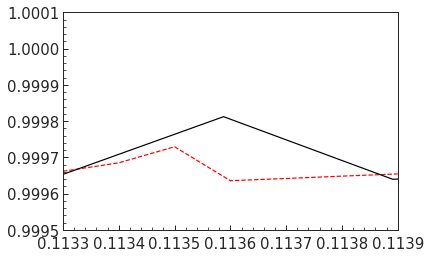

In [36]:
plt.plot(df_omch2_zoom.iloc[:,0], factor*df_omch2_zoom.loc[:,'lp']/df_omch2_zoom.loc[:,'rd'],'r--')
plt.plot(df_omch2.iloc[:,0], factor*df_omch2.loc[:,'lp']/df_omch2.loc[:,'rd'],'k')
plt.xlim(0.1133,0.1139)
plt.ylim(0.9995, 1.0001)

(0.9995, 1.0001)

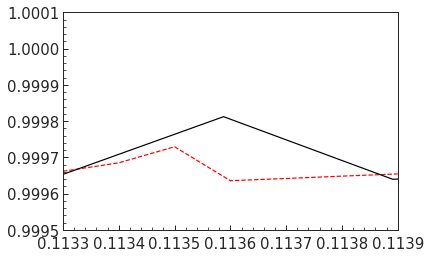

In [36]:
plt.plot(df_omch2_zoom.iloc[:,0], factor*df_omch2_zoom.loc[:,'lp']/df_omch2_zoom.loc[:,'rd'],'r--')
plt.plot(df_omch2.iloc[:,0], factor*df_omch2.loc[:,'lp']/df_omch2.loc[:,'rd'],'k')
plt.xlim(0.1133,0.1139)
plt.ylim(0.9995, 1.0001)

(1.008, 1.015)

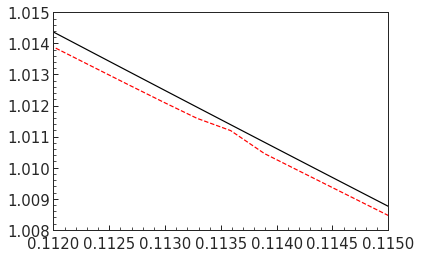

In [27]:
plt.plot(df_omch2.iloc[:,0], df_omch2.loc[:,'rd']/rd_fid,'k')
plt.plot(df_omch2.iloc[:,0], df_omch2.loc[:,'lp']/lp_fid,'r--')
plt.xlim(0.112,0.115)
plt.ylim(1.008, 1.015)

###  Looking at P(k)

In [21]:
# for parameter exploration
step = 0.0001
omch2_vals = np.arange(0.9380, 0.93875, step)

In [22]:
print(len(omch2_vals), "steps")
pk_arr = []
# getting results
# omch2
df_omch2_zoom = pd.DataFrame(columns=['omch2','lp','rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    kh, z, [pk] = results.get_matter_power_spectrum(minkh=kmin,
                                                    maxkh=kmax,
                                                    npoints=1000)
    h = results.hubble_parameter(0)/100
    pk_arr.append(pk)
    #df_omch2_zoom.loc[i] = [omch2, get_lp_2(results), get_rd(results)]

print("Done with omch2")

8 steps
Done with omch2


## LOOK AT THE WEIRD DIP IN THE CURVE. THAT COULD BE THE SOURCE OF ERROR

In [23]:
df = pd.DataFrame(pk_arr).T
df.index = kh
df.columns = omch2_vals

(0.21533875026570967, 1.262923497427687)

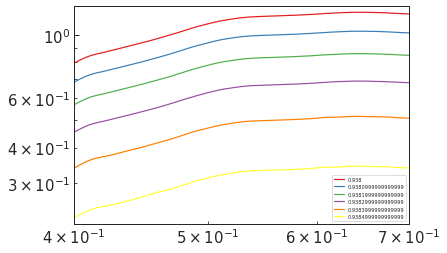

In [24]:
df_plot = df.iloc[:,:-2].subtract(df.iloc[:,-1], axis=0).abs()
df_plot.plot()

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=5)
xmin= 4e-1
xmax = 7e-1

ymax = df_plot.loc[(df_plot.index > xmin) & (df_plot.index < xmax)].max().max()*1.05
ymin= df_plot.loc[(df_plot.index > xmin) & (df_plot.index < xmax)].min().min()*0.95
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [25]:
ymax

1.262923497427687

(2527.0945188751007, 5730.994489023699)

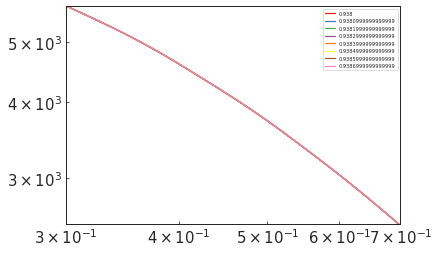

In [26]:
df.plot()
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=5)

xmin= 3e-1
xmax = 7e-1

ymax = df.loc[(df.index > xmin) & (df.index < xmax)].max().max()
ymin= df.loc[(df.index > xmin) & (df.index < xmax)].min().min()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)